In [146]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Video, widgets
from IPython.display import display

%matplotlib inline

In [147]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

In [148]:
def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

def save_first_frame(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Release the video capture object
    cap.release()

    return frame

def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

def get_closest_corners(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(gray, (7, 7), 0) easy 1,2
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # dst = cv2.cornerHarris(blurred, 7, 3, 0.02) easy 1,2
    dst = cv2.cornerHarris(blurred, 7, 3, 0.0)
    dst = cv2.dilate(dst, np.ones((7,7)))
    # corners = np.argwhere(dst > 0.0075 * dst.max()) easy 1,2
    corners = np.argwhere(dst > 0.005 * dst.max())

    # Find corners closest to image corners
    image_corners = np.array([[0, 0], [0, frame.shape[1]], [frame.shape[0], 0], [frame.shape[0], frame.shape[1]]])
    closest_corners = find_closest_points_to_corners(corners, image_corners)

    return closest_corners

def get_target_points(target_square_size=1000):
    target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
    return target_points


def get_corner_diff(ref_corners, new_corners):
    ref_corners = np.array(ref_corners)
    new_corners = np.array(new_corners)

    distances = np.linalg.norm(ref_corners - new_corners, axis=1)
    
    return distances

def correct_corners(corners, ref_corners, marked_change):
    updated_corners = corners.copy()
    good_corners = [(corner, id) for id, corner in enumerate(corners) if not marked_change[id]]
    bad_corners = [(corner, id) for id, corner in enumerate(corners) if marked_change[id]]

    num_incorrect = len(bad_corners)
    
    # print(corners)
    if num_incorrect == 0:
        return corners
    if num_incorrect == 4:
        return ref_corners
    
    good_corner, g_id = good_corners[-1]
    
    for bad_corner, b_id in bad_corners:
        delta_x = ref_corners[b_id][0] - ref_corners[g_id][0]
        delta_y = ref_corners[b_id][1] - ref_corners[g_id][1]

        # Update the position of the faulty corner based on the difference
        updated_corners[b_id][0] = good_corner[0] + delta_x
        updated_corners[b_id][1] = good_corner[1] + delta_y
        
        # print(bad_corner, updated_corners[b_id][0], updated_corners[b_id][1])

    return updated_corners

def get_squares_occupation2(calibrated_image, grid_division, show_img=True):
    print(20)
    for i in range(len(grid_division[:-1])):
        for j in range(len(grid_division[:-1])):
            square = calibrated_image[grid_division[i]:grid_division[i+1], grid_division[j]:grid_division[j+1]]
            
            blue_present = False
            pink_present = False
            pass

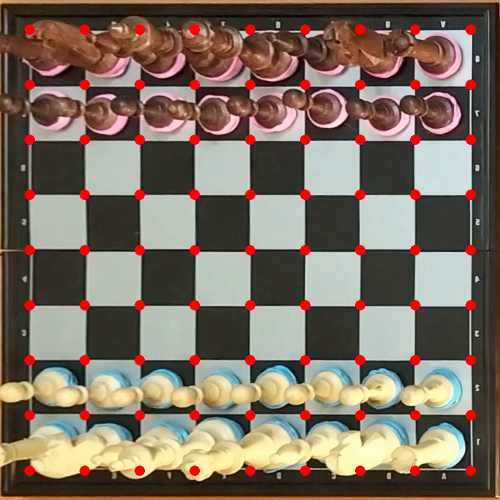

In [157]:
video_path = 'Chess_Data\\chess_new_hard_3.mp4'

first_frame = save_first_frame(video_path)
closest_corners = get_closest_corners(first_frame)
target_points = get_target_points(target_square_size=1000)

closest_corners = np.array([[[y, x]] for x, y in closest_corners], dtype=int)
homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

target_square_size = 1000  # Adjust the size as needed
# Apply the perspective transformation
calibrated_image = cv2.warpPerspective(first_frame, homography_matrix, (target_square_size, target_square_size))

grid_img = calibrated_image.copy()
offset = 59 # Board edge offset
grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)

points = []  
for x in grid_division:
    for y in grid_division:
        points.append((x, y))
        cv2.circle(grid_img, (x, y), 5, (0, 0, 255), 10)

imshow(resize_img(grid_img, 2))

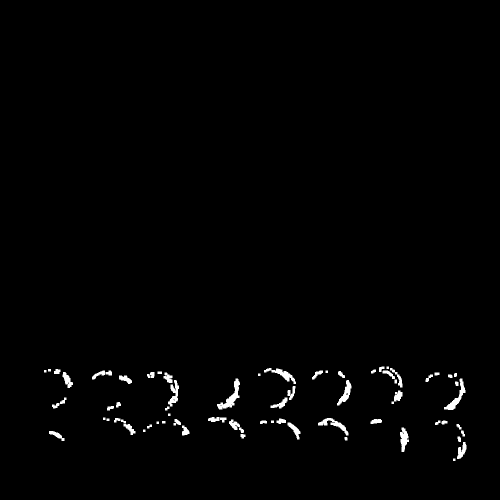

In [132]:
img_rgb = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2RGB)

lower_blue = np.array([50, 105, 155], dtype=np.uint8)
upper_blue = np.array([100, 150, 170], dtype=np.uint8)

mask_lb = cv2.inRange(img_rgb, lower_blue, upper_blue)

kernel = np.ones((5, 5), np.uint8)  # You can adjust the size of the kernel

# Apply dilation to the image
dilated_mask_lb = cv2.dilate(mask_lb, kernel, iterations=1)

# Display the original image and the binary mask
imshow(resize_img(dilated_mask_lb, 2))

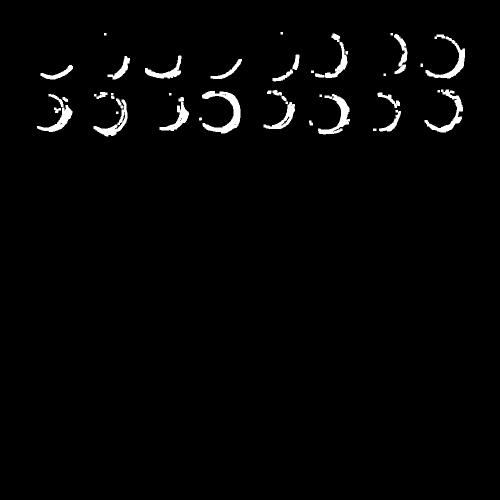

In [131]:
img_rgb = cv2.cvtColor(calibrated_image.copy(), cv2.COLOR_BGR2RGB)

lower_pink = np.array([200, 0, 160], dtype=np.uint8)
upper_pink = np.array([230, 170, 200], dtype=np.uint8)

mask_p = cv2.inRange(img_rgb, lower_pink, upper_pink)

kernel = np.ones((5, 5), np.uint8)  # You can adjust the size of the kernel

# Apply dilation to the image
dilated_mask_p = cv2.dilate(mask_p, kernel, iterations=1)

# Display the original image and the binary mask
imshow(resize_img(dilated_mask_p, 2))

In [91]:
np.sum(np.array([
    [1, 1, 0],
    [1, 2, 1],
    [1, 1, 1]
]))

9

In [ ]:
video_path = 'Chess_Data\\chess_new_B.mp4'

video_capture = cv2.VideoCapture(video_path)

target_square_size = 1000  # Adjust the size as needed
target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)

is_first_frame = True
distance_threshold = 7
history_queue = []
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    closest_corners = get_closest_corners(frame)

    if is_first_frame:
        ref_corners = closest_corners.copy()
        is_first_frame = False

    # If change in corners is big, use last accepted reference corners
    distances = get_corner_diff(ref_corners, closest_corners)

    marked_change = [False, False, False, False]
    for c in range(4):
        if distances[c] > distance_threshold:
            marked_change[c] = True

    corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
    ref_corners = corrected_corners.copy()

    homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

    # Apply the perspective transformation
    calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_image.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # Display the result
    # cv2.imshow('Chessboard focus', grid_img)

    # Display the result
    # cv2.imshow('Chessboard focus', calibrated_image)
        
    cv2.imshow('Chessboard focus', img2)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()